# Introduction

Here we will analyze 2 things:

1) Some reviews and ratings giving by users.
2) We will analyze how well a sentiment analysis pipeline does predicting ratings

Notice that what we are really trying to do, It's to see how well can we predict ratings giving some pipeline from hugging face.

We can then add more layers of complexity, but let us start with a simple problem!

In [21]:
# import 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

import torch
import plotly.express as px

In [22]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "svg"

In [23]:
#pip install --upgrade "kaleido==0.1.*

In [24]:
# if this is true we are using gpu
torch.cuda.is_available()

True

In [25]:
### new library to test out! ###
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

C:\Users\Rober\anaconda3\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [26]:
# Here is the data: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews/data
X_full = pd.read_csv('hotel_reviews.csv')

# This is the real test, but we are going to use a test created by us to use easily ROC-AUC

# X_test_full = pd.read_csv('test.csv', index_col='PassengerId')

# Transported is the target, if there is no target eliminate row associated with it
column_to_predict = "Rating"
X_full.dropna(axis=0, subset=[column_to_predict], inplace=True)


In [27]:
X_full

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


So let us build our candidates and test how well hugging face do predicting labels

In [28]:
candidate_labels = ["Very Positive", 
                    "positive", 
                    "Neutral", 
                    "Negative", 
                    "Very negative"]

In [29]:
# this text it is from one of the data, and it was 5.
def sentiment_analysis(sequence_to_classify,candidate_labels):
    result = classifier(sequence_to_classify, candidate_labels,multi_label=False)
    return result['labels'][0]

In [30]:
# notice they take out the stopwords!!
sequence_to_classify = "cozy stay rainy city, husband spent 7 nights monaco early january 2008. business trip chance come ride.we booked monte carlo suite proved comfortable longish stay, room 905 located street building, street noise not problem view interesting rooms building look dank alley midsection large office building, suite comfortable plenty room spread, bathroom attractive squeaky clean small comparison generous proportions sitting sleeping areas, lots comfortable seating options good lighting plenty storage clothing luggage, hotel staff friendly efficient, housekeeping staff did great job pleasant, requests responded quickly.the location quite good, easy walk pike street market seattle art museum notch shopping dining options.a positive experience,  "
review = sentiment_analysis(sequence_to_classify,candidate_labels)
review

'positive'

So the models think this review correspond to a 4 ratings, let us take just a subset and see what is the average error. 

In [31]:
df = X_full[0:100].copy()
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
95,"excellent stay staff friendly helpful, nice ho...",4
96,return going seattle booked hotel knowing budg...,4
97,terrible hotel approximately 2 weeks ago april...,1
98,great price okay experience stayed inn queen a...,3


In [32]:
# df['sentiment_analysis'] = df['Review'].apply(lambda x:sentiment_analysis(x,candidate_labels)) 

In [33]:
# df.to_csv('100_samples_sentiment_analysis.csv', index=False)  

# Run from here if you already have the dataframe save 

In [34]:
df = pd.read_csv('100_samples_sentiment_analysis.csv')

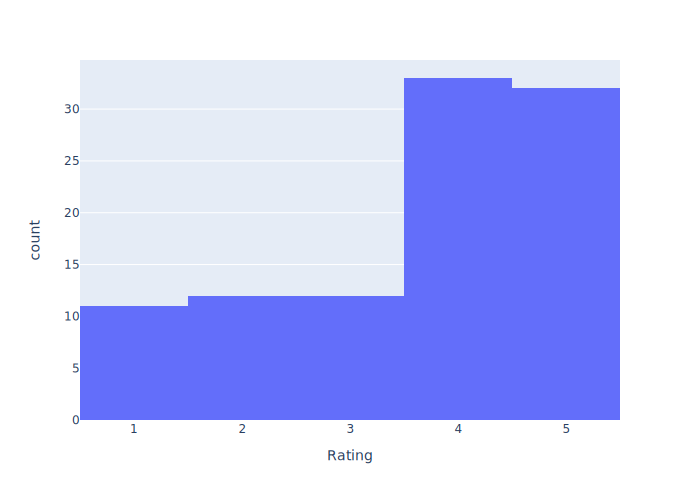

In [35]:
# Quick view of what we got
fig = px.histogram(df, x="Rating")
fig.show()

Well, we got happy customers review!

In [36]:
candidate_labels = ["Very Positive", 
                    "positive", 
                    "Neutral", 
                    "Negative", 
                    "Very negative"]
df = pd.read_csv('100_samples_sentiment_analysis.csv')
df.head()

,Review,Rating,sentiment_analysis
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,positive
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive


So what we could do, It is to change the sentiment_analysis to a scale, so that it can be comparable with rating.

In [37]:
def put_number_sentiment(sentiment,candidate_labels):
    # we start with the best sentiment :)
    sentiment_number = 5 
    for cadidate in candidate_labels:
        if sentiment==cadidate:
            break
        sentiment_number = sentiment_number - 1
    return sentiment_number

In [38]:
df['sentiment_analysis_number'] = df['sentiment_analysis'].apply(lambda x: put_number_sentiment(x,candidate_labels))

In [39]:
df['error'] = df['Rating'] - df['sentiment_analysis_number']
df['abs_error'] = abs(df['error'])

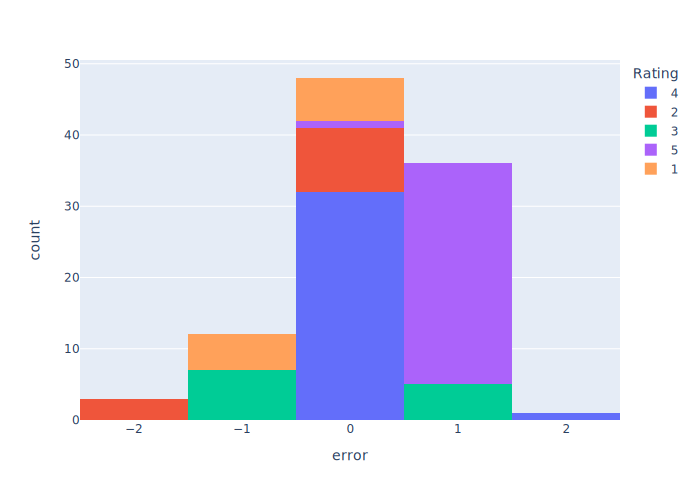

In [40]:
fig = px.histogram(df, x="error", color='Rating')
fig.show()

I know, I know the graph is too colorful! But it actually means something.

The **major error** that the model made was done to the **very positive** review because they were misclassified as just "positive". 
And if we look closely, we can tell the model predict a lot of positive (the green on the left were neutral and they were predicted as positive too!)

How can we solve this, Some ideas:
* Change the original labels, instead of "very positive" and "positive" that may look as a near perfect tag, at least the last one put: "good enough" and "good". (I am thinking in these words: Satisfactory, Acceptable, Decent, Adequate, Fair). The idea is to make positive a less of a broad concepts. There are less error in the lower rate review but maybe that is because of lack of samples in those.

* We can play with multi_label parameters and see if we can make some magic happen adding all the numbers in a smart way.

* We could add more categories and apply a model predict rating base on it. 
or 

* We can train this model a tiny bit on this particular task so it does a better job. (more expensive approach) 


## changing the original labels!

Maybe it is not necesary to find everything perfect to give a 5 star. So, we will add a more suitable set of labels.

In [48]:
def creating_sentiment_analizing_df(candidate_labels,X_full,number_elements):
    df = X_full[0:number_elements].copy()
    df['sentiment_analysis'] = df['Review'].apply(lambda x:sentiment_analysis(x,candidate_labels))
    df['sentiment_analysis_number'] = df['sentiment_analysis'].apply(lambda x: put_number_sentiment(x,candidate_labels))
    df['error'] = df['Rating'] - df['sentiment_analysis_number']
    df['abs_error'] = abs(df['error'])
    fig = px.histogram(df, x="error", color='Rating')
    fig.show()
    return df

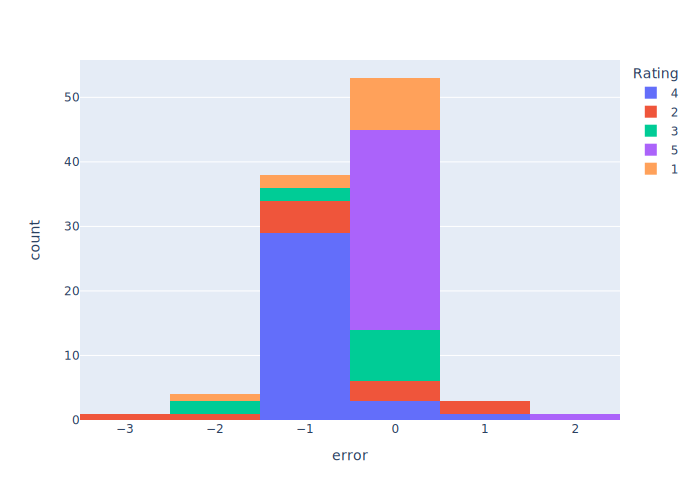

In [49]:
# Let make new labels more especific and see what happened
number_elements = 100
candidate_labels = ["Good hotel experience", 
                    "Good hotel experience but a few aspects can be better", 
                    "Some good hotel aspects and some bad hotel aspects", 
                    "Some bad hotel aspects", 
                    "bad hotel experience"]
df = creating_sentiment_analizing_df(candidate_labels,X_full,number_elements)

In [50]:
df.to_csv('100_samples_sentiment_analysis_2.csv', index=False)  

Wow! we did a better job notice that the error are smaller and more than 50% of ratings were the same as provided by the user. This is extremely interesting, we have to be precise in the category we want to predict so the model do a better job predicting what we want! 

**stayed tune!**